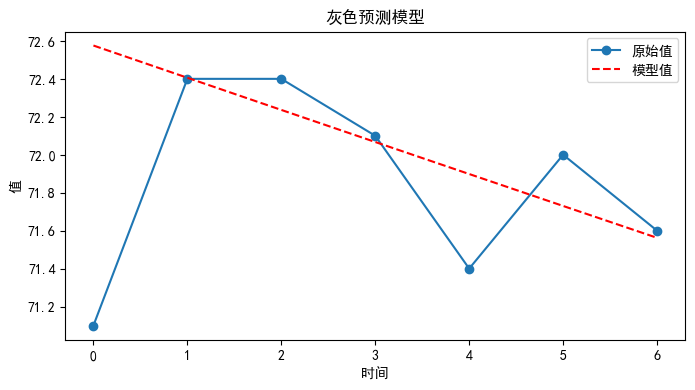

,原始值,模型值,残差,级比偏差,相对误差
0,71.1,72.575644,-1.475644,NaN,-0.020754
1,72.4,72.405741,-0.005741,NaN,-0.000079
2,72.4,72.236237,0.163763,0.002341,0.002262
3,72.1,72.067129,0.032871,0.001803,0.000456
4,71.4,71.898416,-0.498416,0.007368,-0.006981
5,72.0,71.730099,0.269901,0.010744,0.003749
6,71.6,71.562176,0.037824,0.003215,0.000528


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate


def level_check(x, r=(0.1, 2.5)):
    # 级比检验
    n = len(x)
    lambda_x = [x[i-1] / x[i] for i in range(1, n)]
    return all(r[0] <= lambda_x[i] <= r[1] for i in range(n-1))

def GM_11(x0):
    # 建立GM(1,1)模型
    n = len(x0)
    x1 = x0.cumsum() # 一次累加
    z1 = (x1[:n-1] + x1[1:]) / 2.0 # 紧邻均值生成序列
    B = np.array([-z1, np.ones(n-1)]).T
    Yn = x0[1:].reshape((n-1, 1))
    [[a], [b]] = np.linalg.inv(B.T.dot(B)).dot(B.T).dot(Yn) # 计算参数
    f = lambda k: (x0[0]-b/a)*np.exp(-a*(k-1))-(x0[0]-b/a)*np.exp(-a*(k-2)) # 还原值
    return f, a, b


def check_predict(x0, f):
    n = len(x0)
    predict = [f(i+1) for i in range(n)]  # 将预测序列前移一位
    #predict[0] = x0[0]  # 使用原始序列的第一个值替换预测序列的第一个值
    e = x0 - np.array(predict)  # 残差
    relative_e = e / x0  # 相对误差
    lambda_k = [None] + [x0[i] / x0[i-1] for i in range(1, n)]
    lambda_k_hat = [None, None] + [(predict[i]-predict[i-1]) / (predict[i-1]-predict[i-2]) for i in range(2, n)]
    delta_k = [None if lk is None or lhk is None else abs(lk - lhk) for lk, lhk in zip(lambda_k, lambda_k_hat)]  # 级比偏差
    return predict, relative_e, delta_k


def create_df(x0, predict, e, delta_k, relative_e):
    # 创建一个包含原始值、模型值、残差、级比偏差和相对误差的pandas DataFrame
    df = pd.DataFrame({
        '原始值': x0,
        '模型值': predict,
        '残差': e,
        '级比偏差': delta_k,
        '相对误差': relative_e
    })
    return df

def plot_data(x0, predict):
    plt.rcParams['font.sans-serif'] = ['SimHei'] 
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(x0)), x0, 'o-', label='原始值')
    plt.plot(range(len(predict)), predict, 'r--', label='模型值')
    plt.xlabel('时间')
    plt.ylabel('值')
    plt.title('灰色预测模型')
    plt.legend()
    plt.show()

# Test with some data
x0 = np.array([71.1,72.4,72.4,72.1,71.4,72.0,71.6])
if level_check(x0):
    f, a, b = GM_11(x0)
    predict, relative_e, delta_k = check_predict(x0, f)
    e = x0 - predict
    df = create_df(x0, predict, e, delta_k, relative_e)
    plot_data(x0, predict)
else:
    print("级比检验不通过，不能使用灰色预测")
df

          原始值         模型值        残差      级比偏差      相对误差
0  107.482124  105.872224  1.609900       NaN  0.014978
1  121.170629  122.831471 -1.660842       NaN -0.013707
2  145.635116  142.507352  3.127764  0.041715  0.021477
3  165.345803  165.335033  0.010770  0.024843  0.000065
4  191.543228  191.819389 -0.276160  0.001746 -0.001442
5  223.422278  222.546167  0.876111  0.006247  0.003921


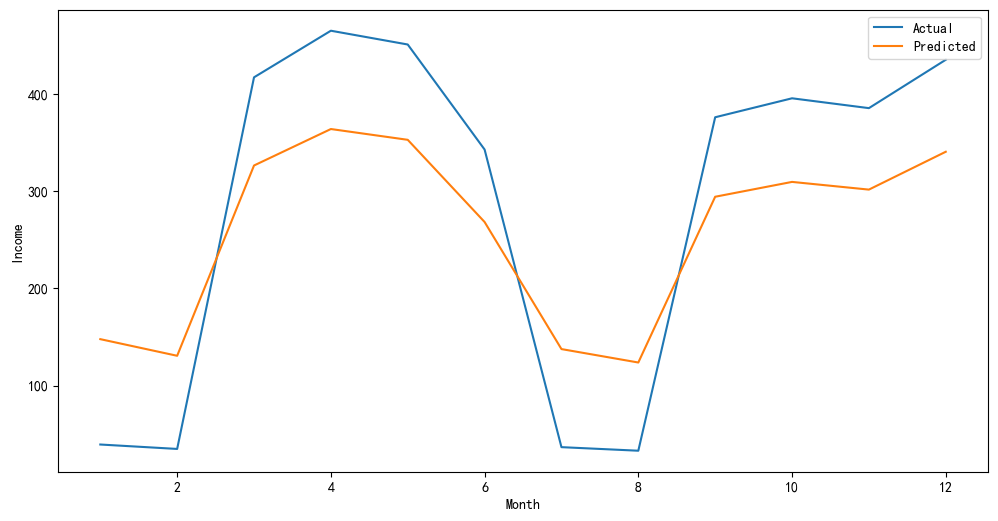

In [10]:
import pandas as pd
import numpy as np

np.random.seed(0)

# 创建年份和月份标签
years = list(range(1997, 2004))
months = list(range(1, 13))

# 创建一个空的列表来存储所有年份的数据
all_data = []

# 初始化第一年的数据
data = [100 + np.random.randn() * 10 for _ in months]
all_data.append(data)

# 为每一年生成数据
for year in years[1:]:
    # 增加一个年度增长率
    growth_rate_year = 1 + np.random.rand() / 10
    # 对每个月应用月度增长率
    data = [prev_month * growth_rate_year * (0.8 if month in [1, 2, 7, 8] else 1.2) for month, prev_month in enumerate(data, start=1)]
    all_data.append(data)

# 将数据转换为二维形状，然后创建DataFrame
data_2d = np.array(all_data)
df = pd.DataFrame(data_2d, index=years, columns=months)

# 更新列名和行名
df.index.name = "Year"
df.columns.name = "Month"

df
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 计算每年的平均收入，并只使用2003年之前的数据
average_income_per_year = df.loc[1997:2002].mean(axis=1)

# 计算每月收入的平均占比
average_monthly_ratio = df.loc[1997:2002].divide(average_income_per_year, axis=0).mean()

# 级比检验
def level_check(x, r=(0.1, 2.5)):
    lambda_x = [x[i-1] / x[i] for i in range(1, len(x))]
    return all(r[0] <= lambda_x[i] <= r[1] for i in range(len(x)-1))

if not level_check(average_income_per_year.values):
    print("级比检验不通过，不能使用灰色预测")
    exit()

# 灰色预测模型
x0 = average_income_per_year.values
n = len(x0)
x1 = x0.cumsum() # 一次累加
z1 = (x1[:n-1] + x1[1:]) / 2.0 # 紧邻均值生成序列
B = np.array([-z1, np.ones(n-1)]).T
Yn = x0[1:].reshape((n-1, 1))
[[a], [b]] = np.linalg.inv(B.T.dot(B)).dot(B.T).dot(Yn) # 计算参数
f = lambda k: (x0[0]-b/a)*np.exp(-a*(k-1))-(x0[0]-b/a)*np.exp(-a*(k-2)) # 还原值

# 预测2003年的平均收入
average_income_2003_predicted = f(n+1)

# 将预测的平均收入分配到每个月
income_2003_predicted = average_monthly_ratio * average_income_2003_predicted

# 创建一个包含原始值、模型值、残差、级比偏差和相对误差的pandas DataFrame
def create_df(x0, f):
    n = len(x0)
    predict = [f(i) for i in range(1, n+1)]
    e = x0 - np.array(predict)  # 残差
    relative_e = e / x0  # 相对误差
    lambda_k = [None] + [x0[i] / x0[i-1] for i in range(1, n)]
    lambda_k_hat = [None, None] + [(predict[i]-f(i-1)) / (predict[i-1]-f(i-2)) for i in range(2, n)]
    delta_k = [None if lk is None or lhk is None else abs(lk - lhk) for lk, lhk in zip(lambda_k, lambda_k_hat)]  # 级比偏差
    df = pd.DataFrame({
        '原始值': x0,
        '模型值': predict,
        '残差': e,
        '级比偏差': delta_k,
        '相对误差': relative_e
    })
    return df

# 打印模型验证信息
print(create_df(average_income_per_year.values, f))

# 比较预测值和实际值
plt.figure(figsize=(12, 6))
plt.plot(df.columns, df.loc[2003], label='Actual')
plt.plot(df.columns, income_2003_predicted, label='Predicted')
plt.xlabel('Month')
plt.ylabel('Income')
plt.legend()
plt.show()
